# PCA with Image Dataset CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.  

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.  

The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck  

In [1]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# The dataset is now loaded into memory and ready for use.


c:\Users\Belgau\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### Reshape

In [10]:
print(train_images.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Since each image in CIFAR-10 is a 3-dimensional array (32x32 pixels with 3 color channels), and PCA requires a 2-dimensional input (samples x features), you will need to reshape the image arrays into vectors. This means converting the 32x32x3 arrays into 3072-length vectors.

In [11]:
# Reshape the training and testing image arrays
train_images_flat = train_images.reshape((train_images.shape[0], -1))
test_images_flat = test_images.reshape((test_images.shape[0], -1))

### Normalize

In [12]:
# Normalize the pixel values to range 0-1
train_images_flat = train_images_flat.astype('float32') / 255
test_images_flat = test_images_flat.astype('float32') / 255

In [14]:
# Check shapes and data ranges
print("Training images shape:", train_images_flat.shape)
print("Test images shape:", test_images_flat.shape)
print("Min and max pixel values:", train_images_flat.min(), train_images_flat.max())


Training images shape: (50000, 3072)
Test images shape: (10000, 3072)
Min and max pixel values: 0.0 1.0


### Principal Component Analysis

In [15]:
from sklearn.decomposition import PCA

# Initialize PCA, choose the number of components e.g., 100 for initial experiments
pca = PCA(n_components=100)

# Fit PCA on the training data
pca.fit(train_images_flat)

# Transform both the training and testing data
train_images_pca = pca.transform(train_images_flat)
test_images_pca = pca.transform(test_images_flat)

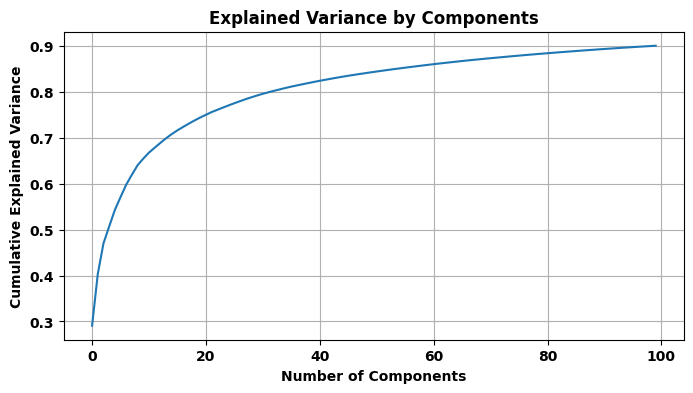

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()


### Modeling

Build an ML model for the original dataset.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split training dataset into training and validation set
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    train_images_flat, train_labels.flatten(), test_size=0.2, random_state=42
)

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_orig, y_train_orig)


DecisionTreeClassifier()

Train on PCA-reduced data

In [21]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    train_images_pca, train_labels.flatten(), test_size=0.2, random_state=42
)

tree_model_PCA = DecisionTreeClassifier()
tree_model_PCA.fit(X_train_pca, y_train_pca)

DecisionTreeClassifier()

Compare performance

In [22]:
from sklearn.metrics import accuracy_score

# Evaluate original model
accuracy_orig = accuracy_score(y_test_orig, tree_model.predict(X_test_orig))

# Evaluate PCA model
accuracy_pca = accuracy_score(y_test_pca, tree_model_PCA.predict(X_test_pca))

print("Accuracy on original data:", accuracy_orig)
print("Accuracy on PCA-reduced data:", accuracy_pca)


Accuracy on original data: 0.2554
Accuracy on PCA-reduced data: 0.2624
